In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools
from cartopy.util import add_cyclic_point
from IPython.display import Image

In [2]:
start_yr = 32
num_years = 10
endyr = start_yr + num_years 
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
user = 'kristenk'

In [3]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 32 !
doing simulation year 33 !
doing simulation year 34 !
doing simulation year 35 !
doing simulation year 36 !
doing simulation year 37 !
doing simulation year 38 !
doing simulation year 39 !
doing simulation year 40 !
doing simulation year 41 !


In [4]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

In [5]:
variables = ['zoo1C','zoo2C','zoo3C','zoo4C','graze_diaz_zoo2','graze_cocco_zoo2',
             'graze_sp_zoo2','graze_zoo1_zoo2',
             'graze_diat_zoo3','graze_diaz_zoo3',
             'graze_cocco_zoo3','graze_zoo2_zoo3','graze_diat_zoo4','graze_zoo3_zoo4'] 
coords = {'x':'TLONG','y':'TLAT'}

In [6]:
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [7]:
ds=cesm_mon_ds.mean(dim='time')

In [8]:
ds.graze_diat_zoo4

<xarray.DataArray 'graze_diat_zoo4' (z_t_150m: 15, nlat: 384, nlon: 320)>
dask.array<mean_agg-aggregate, shape=(15, 384, 320), dtype=float32, chunksize=(15, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * z_t_150m  (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Diatom Grazing to Large Mesozooplankton
    units:         mmol/m^3/s
    coordinates:   TLONG TLAT z_t_150m time
    grid_loc:      3114
    cell_methods:  time: mean

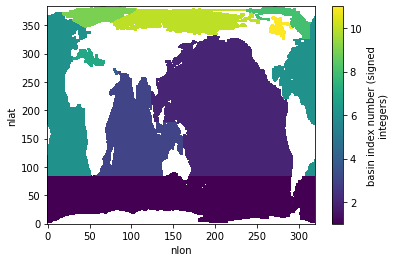

In [9]:
ds.REGION_MASK.where(ds.REGION_MASK>0.).plot()

### plotting function

In [10]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### grab POP grid

In [11]:
grid = pop_tools.get_grid('POP_gx1v6')
lons = grid.TLONG
lats = grid.TLAT

### make a trophic level 2 pop grid

In [12]:
## create Ft grid
TL2 = np.full((384, 320), 2, dtype=float)
TL2 = xr.DataArray(TL2)
TL2 = TL2.rename({'dim_0':'nlat',
                  'dim_1':'nlon'})

### zoo1 trophic level -- these are just herbivores so it's 2

In [13]:
zoo1_TL = TL2.where(ds.REGION_MASK>0.)

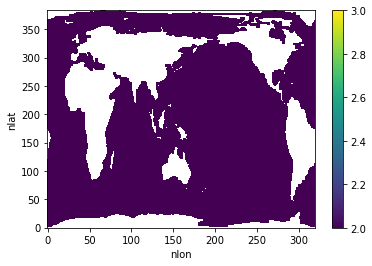

In [14]:
zoo1_TL.plot(vmin=2,vmax=3)

### do zoo2 grazing weighted trophic level for each depth level

In [15]:
graze_weight_TLsum = (ds.graze_diaz_zoo2 * 2. + ds.graze_cocco_zoo2 * 2. + ds.graze_sp_zoo2 * 2. + ds.graze_zoo1_zoo2 * (zoo1_TL + 1.))
graze_weight_sum = (ds.graze_diaz_zoo2 + ds.graze_cocco_zoo2 + ds.graze_sp_zoo2 + ds.graze_zoo1_zoo2)

zoo2_TL = graze_weight_TLsum / graze_weight_sum

### now create biomass weighted TL for zoo2

In [16]:
biomass_weight_TLsum = (ds.zoo2C * zoo2_TL).sum(dim='z_t_150m')
biomass_weight_sum = ds.zoo2C.sum(dim='z_t_150m')

zoo2_TL_zavg = biomass_weight_TLsum/biomass_weight_sum

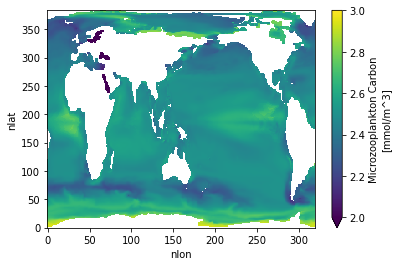

In [17]:
zoo2_TL_zavg.plot(vmin=2,vmax=3)

### do zoo3 grazing weighted trophic level for each depth level

In [18]:
graze_weight_TLsum = (ds.graze_diaz_zoo3 * 2. + ds.graze_cocco_zoo3 * 2. + ds.graze_diat_zoo3 * 2. + ds.graze_zoo2_zoo3 * (zoo2_TL + 1.))
graze_weight_sum = (ds.graze_diaz_zoo3 + ds.graze_cocco_zoo3 + ds.graze_diat_zoo3 + ds.graze_zoo2_zoo3)

zoo3_TL = graze_weight_TLsum / graze_weight_sum

### now do biomass-weighted depth average for zoo3

In [19]:
biomass_weight_TLsum = (ds.zoo3C * zoo3_TL).sum(dim='z_t_150m')
biomass_weight_sum = ds.zoo3C.sum(dim='z_t_150m')

zoo3_TL_zavg = biomass_weight_TLsum/biomass_weight_sum

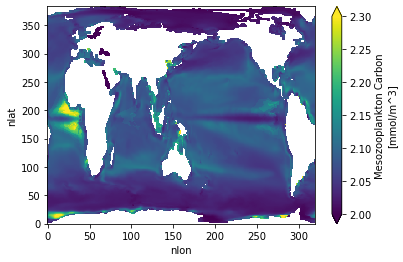

In [20]:
zoo3_TL_zavg.plot(vmin=2,vmax=2.3)

### do zoo4 grazing weighted trophic level for each depth level

In [21]:
graze_weight_TLsum = (ds.graze_diat_zoo4 * 2. + ds.graze_zoo3_zoo4 * (zoo3_TL + 1.))
graze_weight_sum = (ds.graze_diat_zoo4 + ds.graze_zoo3_zoo4)

zoo4_TL = graze_weight_TLsum / graze_weight_sum

### now biomass weighted depth average for zoo4 TL

In [22]:
biomass_weight_TLsum = (ds.zoo4C * zoo4_TL).sum(dim='z_t_150m')
biomass_weight_sum = ds.zoo4C.sum(dim='z_t_150m')

zoo4_TL_zavg = biomass_weight_TLsum/biomass_weight_sum

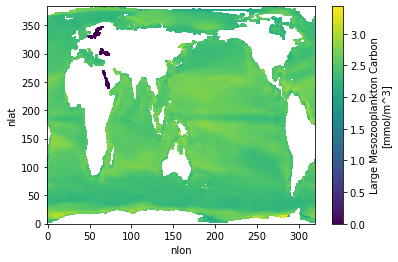

In [23]:
zoo4_TL_zavg.plot()

### Make a set of maps for TL for each ZFT

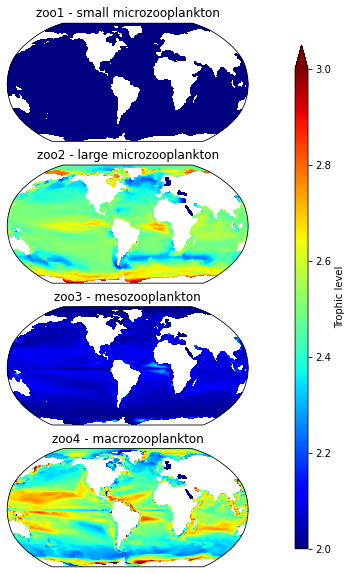

In [24]:
fig = plt.figure(figsize=(6,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo1 - small microzooplankton', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_TL)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=3,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo2 - large microzooplankton', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, zoo2_TL_zavg)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=3,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo3 - mesozooplankton', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_TL_zavg)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=3,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4 - macrozooplankton', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_TL_zavg)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=3,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(pc, extend='max', cax=cbar_ax, label='Trophic level');

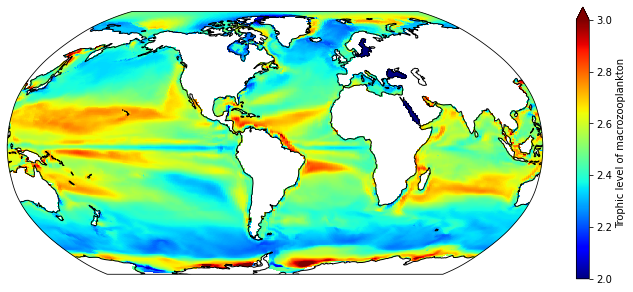

In [25]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_TL_zavg)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=3,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level of macrozooplankton')
fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/TL_macrozoo.png',dpi=300)

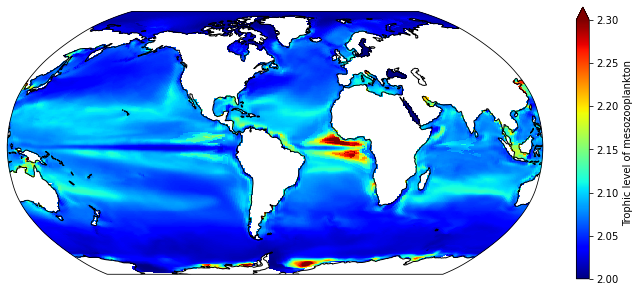

In [26]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_TL_zavg)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=2.3,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level of mesozooplankton')


### depth integrate biomass to use for weighting

In [27]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

### make a mean _microzooplankton_ TL and a mean  _large zooplankton_ TL

In [29]:
microzoo_TL = (zoo1_TL * ds.zoo1C_zint + zoo2_TL_zavg * ds.zoo2C_zint) / (ds.zoo1C_zint + ds.zoo2C_zint)

In [30]:
largezoo_TL = (zoo3_TL_zavg * ds.zoo3C_zint + zoo4_TL_zavg * ds.zoo4C_zint) / (ds.zoo3C_zint + ds.zoo4C_zint)

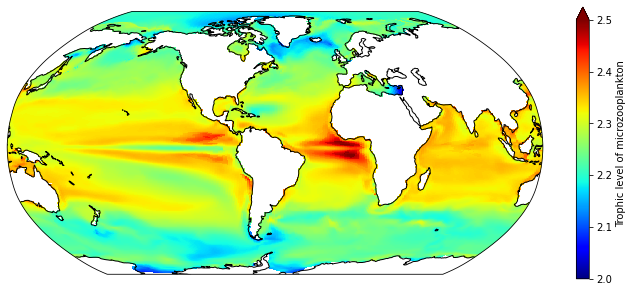

In [33]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, microzoo_TL)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=2.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level of microzooplankton')


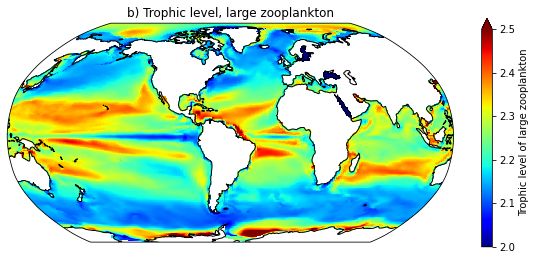

In [36]:
fig = plt.figure(figsize=(10,4.2))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, largezoo_TL)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=2.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
ax.set_title('b) Trophic level, large zooplankton', fontsize=12)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level of large zooplankton')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/TL_largezoo.png',dpi=300)

### Make mean trophic level for all zooplankton

In [37]:
zoo_TL = (zoo1_TL * ds.zoo1C_zint + zoo2_TL_zavg * ds.zoo2C_zint + zoo3_TL_zavg * ds.zoo3C_zint + zoo4_TL_zavg * ds.zoo4C_zint) / (ds.zoo1C_zint + ds.zoo2C_zint + ds.zoo3C_zint + ds.zoo4C_zint)

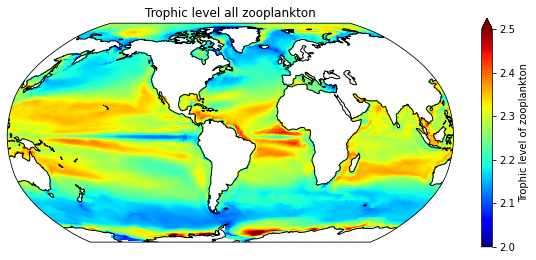

In [38]:
fig = plt.figure(figsize=(10,4.2))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, zoo_TL)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=2.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
ax.set_title('Trophic level all zooplankton', fontsize=12)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level of zooplankton')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/TL_allzoo.png',dpi=300)